In [ ]:
import numpy as np
import pandas as pd

import os
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np

def load_data(base_dir, sample_n=50):
    all_data = []
    tickers_seen = set()

    for root, _, files in os.walk(base_dir):
        np.random.shuffle(files)
        for file in files:
            if file.endswith('.csv'):
                path = os.path.join(root, file)
                try:
                    # ticker z nazwy pliku
                    ticker = os.path.splitext(file)[0]
                    if ticker in tickers_seen:
                        continue

                    # wczytanie danych zgodnie z nowym formatem
                    df = pd.read_csv(path, skiprows=2, header=None,
                                     names=["Date", "Close", "High", "Low", "Open", "Volume"],
                                     usecols=["Date", "Close"])
                    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")
                    df = df.dropna(subset=["Date", "Close"])

                    if df.shape[0] > 100:
                        df["TICKER"] = ticker
                        all_data.append(df)
                        tickers_seen.add(ticker)

                        if len(tickers_seen) >= sample_n:
                            break
                except Exception:
                    continue
        if len(tickers_seen) >= sample_n:
            break

    if not all_data:
        raise Exception("Brak danych")

    return pd.concat(all_data, ignore_index=True)


def prepare_pivot(df, start_year=2020, end_year=2025, max_nan_percent=5.0):
    df = df[(df["Date"].dt.year >= start_year) & (df["Date"].dt.year <= end_year)]
    pivot = df.pivot(index="Date", columns="TICKER", values="Close").sort_index()
    pivot = pivot[pivot.index.weekday < 5]  # usuń weekendy
    nans = pivot.isna().sum() / len(pivot) * 100
    good_tickers = nans[nans <= max_nan_percent].index.tolist()
    pivot = pivot[good_tickers].fillna(method="ffill").fillna(method="bfill")
    return pivot



def extract_features(price_df: pd.DataFrame, window: int = 20):
    returns = price_df.pct_change().dropna()
    momentum = returns.tail(window).mean()
    volatility = returns.tail(window).std()
    sharpe = momentum / volatility
    cum_returns = (1 + returns.tail(window)).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    mdd = drawdown.min()
    corr_matrix = returns.tail(window).corr()
    total_corr = corr_matrix.sum() - 1  # bez własnej korelacji
    features = pd.DataFrame({
        'MOM': momentum,
        'VOL': volatility,
        'SHARPE': sharpe,
        'MDD': mdd,
        'CORR': total_corr
    })
    return features.fillna(0)


def pso_fitness_advanced(weights, features,
                         lambda_mom=0.0, lambda_vol=0.4,
                         lambda_mdd=0.3, lambda_sharpe=0.2,
                         lambda_corr=0.1):
    port_mom = np.sum(weights * features["MOM"])
    port_vol = np.sqrt(np.sum((weights * features["VOL"])**2))
    port_sharpe = port_mom / port_vol if port_vol != 0 else 0
    port_mdd = np.sum(weights * features["MDD"])
    port_corr = np.sum(weights * features["CORR"])
    fitness = (
        - lambda_mom * port_mom +
        lambda_vol * port_vol +
        lambda_mdd * abs(port_mdd) -
        lambda_sharpe * port_sharpe +
        lambda_corr * port_corr
    )
    return fitness


def pso_optimize_advanced(features: pd.DataFrame,
                          n_particles=100, n_iterations=300, max_weight=0.2,
                          lambda_mom=0.0, lambda_vol=0.4,
                          lambda_mdd=0.3, lambda_sharpe=0.2,
                          lambda_corr=0.1):
    n_assets = len(features)
    particles = np.random.dirichlet(np.ones(n_assets), size=n_particles)
    velocities = np.zeros_like(particles)
    personal_best = particles.copy()
    personal_scores = np.array([
        pso_fitness_advanced(p, features,
                             lambda_mom, lambda_vol, lambda_mdd,
                             lambda_sharpe, lambda_corr)
        for p in particles
    ])
    global_best_idx = np.argmin(personal_scores)
    global_best = personal_best[global_best_idx].copy()

    for _ in range(n_iterations):
        for i in range(n_particles):
            r1, r2 = np.random.rand(n_assets), np.random.rand(n_assets)
            velocities[i] = 0.5 * velocities[i] + \
                            1.4 * r1 * (personal_best[i] - particles[i]) + \
                            1.4 * r2 * (global_best - particles[i])
            particles[i] += velocities[i]
            particles[i] = np.clip(particles[i], 0, max_weight)
            particles[i] /= particles[i].sum() if particles[i].sum() > 0 else 1
            score = pso_fitness_advanced(particles[i], features,
                                         lambda_mom, lambda_vol,
                                         lambda_mdd, lambda_sharpe,
                                         lambda_corr)
            if score < personal_scores[i]:
                personal_best[i] = particles[i].copy()
                personal_scores[i] = score
                if score < personal_scores[global_best_idx]:
                    global_best = particles[i].copy()
                    global_best_idx = i

    return global_best

def realistic_pso_raw_advanced(pivoted_prices: pd.DataFrame,
                                feature_window: int = 20,
                                rebalance_period: int = 5,
                                n_particles: int = 100,
                                n_iterations: int = 300,
                                max_weight: float = 0.2,
                                lambda_mom: float = 0.0,
                                lambda_vol: float = 0.4,
                                lambda_mdd: float = 0.3,
                                lambda_sharpe: float = 0.2,
                                lambda_corr: float = 0.1,
                                fee_rate: float = 0.001):  
    returns = pivoted_prices.pct_change().dropna()
    returns_test = returns[returns.index.year == 2025]
    dates = returns_test.index

    capital = 1.0
    capital_timeline = []
    weights_log = []
    shares = None
    prev_weights = pd.Series(0.0, index=pivoted_prices.columns)

    for start in range(0, len(dates), rebalance_period):
        end = min(start + rebalance_period, len(dates))
        rebalance_date = dates[start]
        period_dates = dates[start:end]
        current_prices = pivoted_prices.loc[rebalance_date]

        price_history = pivoted_prices.loc[:rebalance_date].tail(feature_window + 1)
        features = extract_features(price_history, window=feature_window)

        new_weights = pso_optimize_advanced(
            features,
            n_particles=n_particles,
            n_iterations=n_iterations,
            max_weight=max_weight,
            lambda_mom=lambda_mom,
            lambda_vol=lambda_vol,
            lambda_mdd=lambda_mdd,
            lambda_sharpe=lambda_sharpe,
            lambda_corr=lambda_corr
        )

       
        total_value = (shares * current_prices).sum() if shares is not None else capital

    
        cost = fee_rate * total_value * np.sum(np.abs(new_weights - prev_weights))
        total_value_after_cost = total_value - cost
        capital = total_value_after_cost  # aktualizacja kapitału

       
        shares = (new_weights * total_value_after_cost) / current_prices
        prev_weights = new_weights

        for date in period_dates:
            prices_today = pivoted_prices.loc[date]
            portfolio_value = np.sum(shares * prices_today)
            capital_timeline.append((date, portfolio_value))

        for ticker, w in zip(pivoted_prices.columns, new_weights):
            weights_log.append({
                "Date": rebalance_date,
                "Ticker": ticker,
                "Weight": w
            })

    capital_series = pd.Series(dict(capital_timeline))
    weights_df = pd.DataFrame(weights_log)
    return capital_series, weights_df


<Axes: >

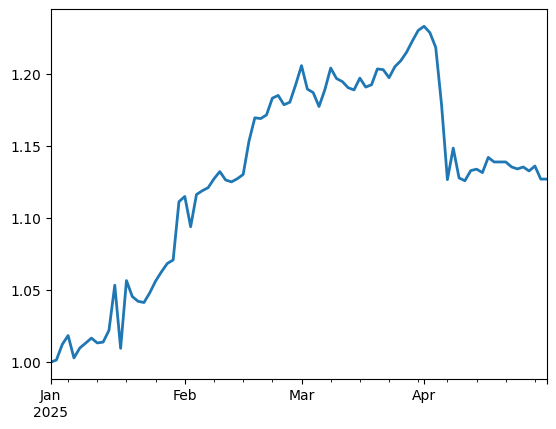

In [8]:

#CAGR	Sharpe	MaxDD	Particles	Iterations	MaxWeight	FeatureWindow	RebalancePeriod	λ_mom	λ_vol	λ_mdd	λ_sharpe	λ_corr
#0.519129	3.480058	-0.041738	100	300	0.15	5	5	0.2	0.1	0.1	0.3	0.0
capital_raw, weights_raw = realistic_pso_raw_advanced(
    pivoted_prices=pivoted,
    feature_window=20,
    rebalance_period=5,
    n_particles=200,
    n_iterations=300,
    max_weight=0.15,
    lambda_mom=0.2,
    lambda_vol=0.3,
    lambda_mdd=0.3,
    lambda_sharpe=0.3,
    lambda_corr=0.3
)
capital_raw.plot(label="Realistic PSO Raw", linewidth=2)

In [1]:
from itertools import product

def grid_search_pso_raw(pivoted: pd.DataFrame):
    # Siatka parametrów
    lambda_combinations = [
        {"mom": 0.2, "vol": 0.1, "mdd": 0.1, "sharpe": 0.3, "corr": 0.0},
        {"mom": 0.1, "vol": 0.2, "mdd": 0.4, "sharpe": 0.2, "corr": 0.1},
        {"mom": 0.0, "vol": 0.4, "mdd": 0.4, "sharpe": 0.1, "corr": 0.3},
    ]
    particle_options = [100,200]
    iteration_options = [ 200, 300]
    max_weight_options = [ 0.15]
    feature_window_options = [5, 10, 20]
    rebalance_options = [3, 5]

    results = []
    total = (len(lambda_combinations) *
             len(particle_options) *
             len(iteration_options) *
             len(max_weight_options) *
             len(feature_window_options) *
             len(rebalance_options))
    counter = 1

    for lambdas, n_p, n_iter, max_w, feat_win, reb_period in product(
        lambda_combinations,
        particle_options,
        iteration_options,
        max_weight_options,
        feature_window_options,
        rebalance_options
    ):
        print(f"({counter}/{total}) Test: λ={lambdas}, P={n_p}, I={n_iter}, W={max_w}, F={feat_win}, R={reb_period}")
        counter += 1
        try:
            capital_series, _ = realistic_pso_raw_advanced(
                pivoted_prices=pivoted,
                feature_window=feat_win,
                rebalance_period=reb_period,
                n_particles=n_p,
                n_iterations=n_iter,
                max_weight=max_w,
                lambda_mom=lambdas["mom"],
                lambda_vol=lambdas["vol"],
                lambda_mdd=lambdas["mdd"],
                lambda_sharpe=lambdas["sharpe"],
                lambda_corr=lambdas["corr"]
                
            )

            returns = capital_series.pct_change().dropna()
            mean_return = returns.mean() * 252
            std_dev = returns.std() * np.sqrt(252)
            sharpe_ratio = mean_return / std_dev if std_dev != 0 else 0
            cum_returns = (1 + returns).cumprod()
            peak = cum_returns.cummax()
            drawdown = (cum_returns - peak) / peak
            max_drawdown = drawdown.min()
            start_value = capital_series.iloc[0]
            end_value = capital_series.iloc[-1]
            n_years = (capital_series.index[-1] - capital_series.index[0]).days / 365.25
            cagr = (end_value / start_value) ** (1 / n_years) - 1

            results.append({
                "CAGR": cagr,
                "Sharpe": sharpe_ratio,
                "MaxDD": max_drawdown,
                "Particles": n_p,
                "Iterations": n_iter,
                "MaxWeight": max_w,
                "FeatureWindow": feat_win,
                "RebalancePeriod": reb_period,
                **{f"λ_{k}": v for k, v in lambdas.items()}
            })
        except Exception as e:
            print(f"❌ Error: {e}")
            continue

    df_results = pd.DataFrame(results).sort_values(by="Sharpe", ascending=False)
   
    return df_results


NameError: name 'pd' is not defined